In [1]:
import events
import settings
import metrics
import plotting

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import sparse
import pandas as pd
import pprint

import networkx as nx
import os
import itertools

## Loading log data 

In [2]:
logname = 20221003094751
log = f"..//logs//{logname}"
configs = settings.load(f"{log}//settings.log")
stats = metrics.load(f"{log}//metrics.log")

In [3]:
events.analyze(
    f"{log}//events",
    counter := events.EventCallback(events.EventCounterData),
    updates := events.EventCallback(events.UpdatesData),
    timeline := events.EventCallback(events.TimelineData),
    reachability := events.EventCallback(events.ReachabilityData),
    received := events.EventCallback(events.ReceivedData))

  0%|          | 0.00/132M [00:00<?, ?it/s]

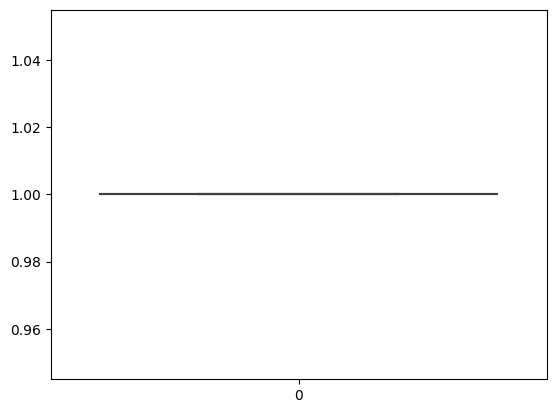

In [31]:
coeffs = np.array([config.msg.send_coeff for config in configs])
num_updates = np.array([update.num_updated for update in updates])
groups = np.array([num_updates[coeffs == c] for c in np.unique(coeffs)])
normal_groups = groups.T / np.expand_dims(groups.max(axis=0), axis=1)
sns.boxplot(normal_groups);

## Updates

In [4]:
def updates_hist_plot(data: events.UpdatesData) -> None:
    opts = {"binwidth": 0.01, "stat": "density"}
    sns.histplot([data.symptoms, data.exposures], **opts)
    plt.legend(["Symptom score", "Exposure score"])
    plt.xlabel("Risk score")

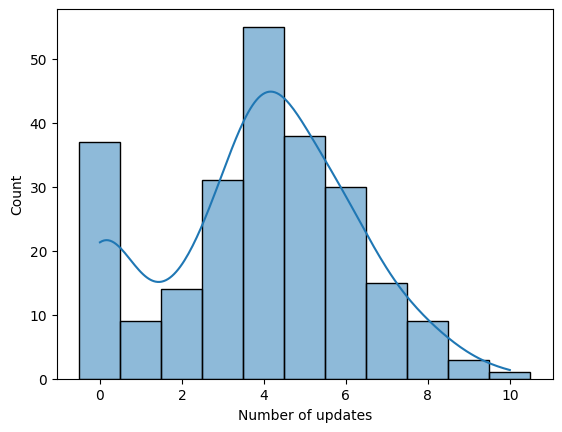

In [5]:
sns.histplot(updates[0].updates, discrete=True, kde=True);
plt.xlabel("Number of updates");

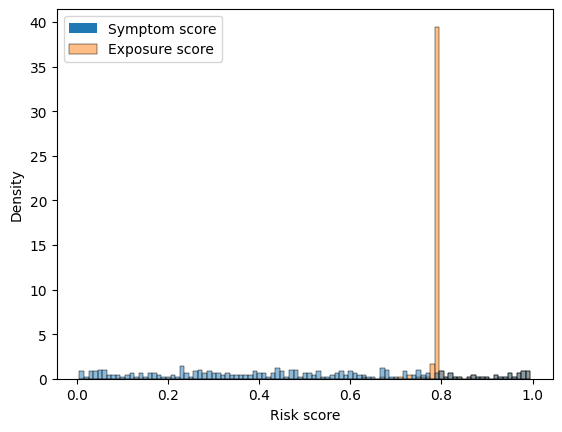

In [6]:
updates_hist_plot(updates[0])

# Received

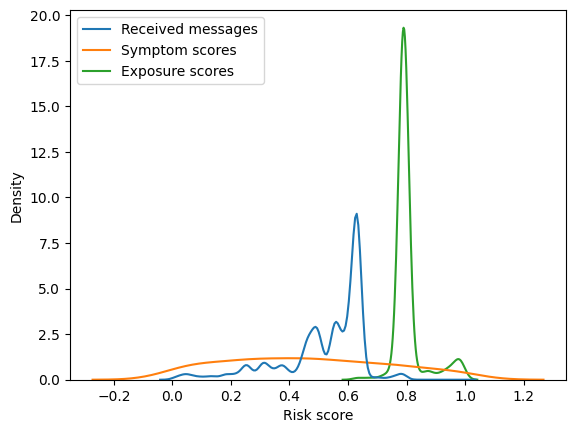

In [7]:
sns.kdeplot({
    "Received messages": received[0].values, 
    "Symptom scores": updates[0].symptoms,
    "Exposure scores": updates[0].exposures},
    common_norm=False);
plt.xlabel("Risk score");

## Timeline

In [10]:
iteration = 0
x_axis = "time"

positions, n_events = plotting.event_plot_positions(timeline[iteration], x_axis=x_axis)
start = positions[2][0]  # First contact msg
end = positions[0][-1]  # Last recevied msg
print(runtime := end - start)

0.594


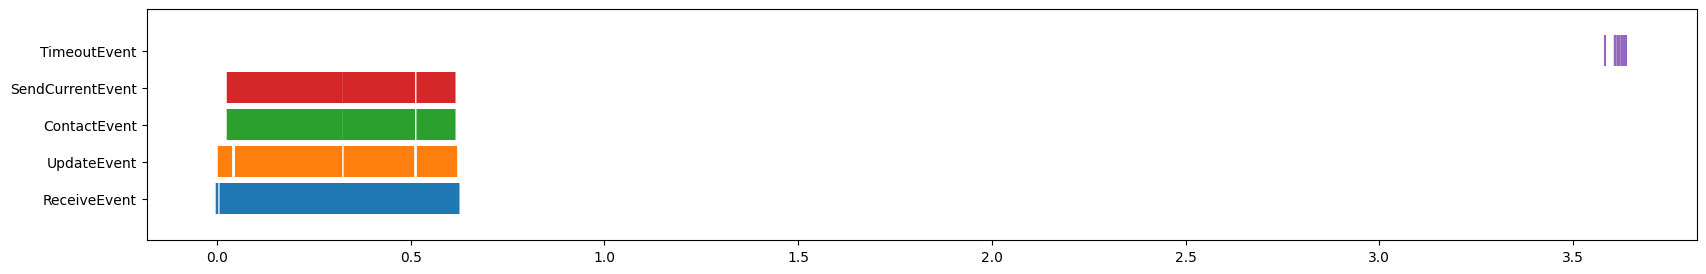

In [11]:
line_len = 5
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
offsets = np.arange(n_events) * (line_len + 1)
ax.axes.set_yticks(offsets)
ax.axes.set_yticklabels(timeline[0].i2e)
ax.eventplot(
    positions,
    colors=[f"C{i}" for i in range(n_events)],
    linelengths=np.repeat(line_len, n_events),
    lineoffsets=np.arange(n_events) * (line_len + 1), 
);

## Reachability

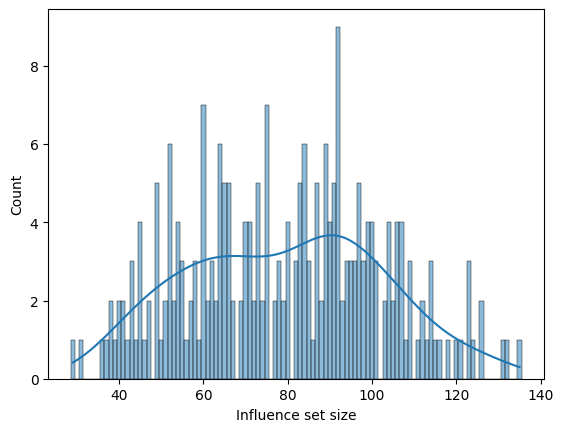

In [12]:
sns.histplot(reachability[0].influence(), discrete=True, kde=True);
plt.xlabel("Influence set size");

In [13]:
reachability[0].reach_ratio()

0.32743665050201487

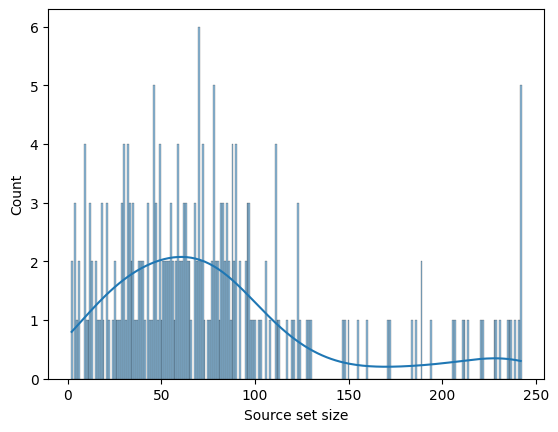

In [14]:
sns.histplot(reachability[0].source_size(), discrete=True, kde=True);
plt.xlabel("Source set size");

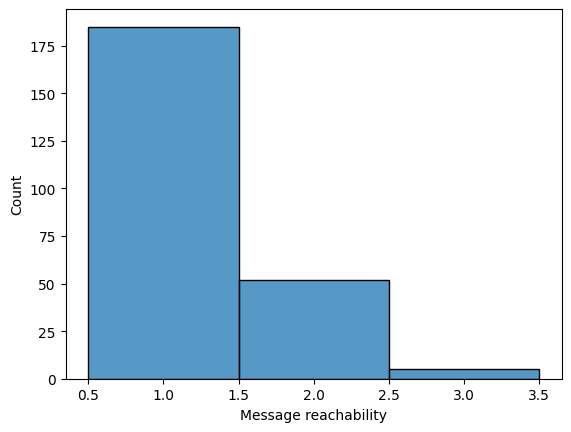

In [15]:
sns.histplot(reachability[0].msg_reach(), discrete=True);
plt.xlabel("Message reachability");

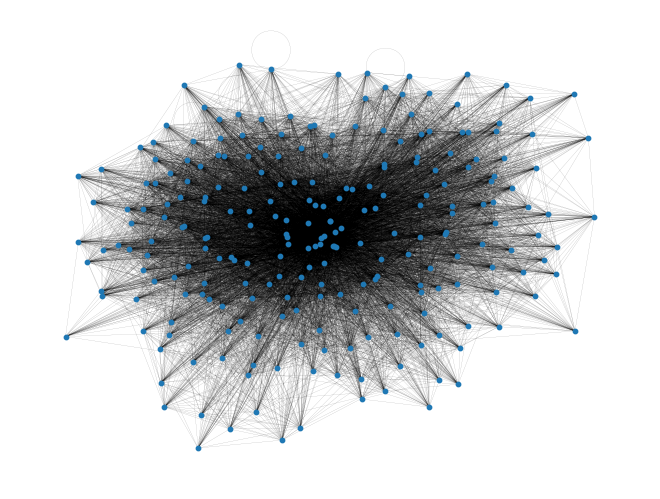

In [16]:
graph = nx.from_scipy_sparse_array(reachability[0].adj)
plt.figure(dpi=100)
nx.draw(
    graph,
    pos=nx.spring_layout(graph),
    width=0.05,
    with_labels=False,
    node_size=10)